<a href="https://colab.research.google.com/github/Kirtan011/Video-Analytics-Surveillance-System/blob/main/DCSASS_yolo_activity_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def print_tree(base_path, indent="", max_items=3):
    """
    Recursively print folder structure:
    - Shows first 'max_items' files/folders in each directory
    - Prints "... +X more" if more items exist
    """
    try:
        items = sorted(os.listdir(base_path))
    except PermissionError:
        print(indent + "❌ [Permission Denied]")
        return

    for i, item in enumerate(items[:max_items]):
        path = os.path.join(base_path, item)
        if os.path.isdir(path):
            print(f"{indent}📂 {item}/")
            print_tree(path, indent + "   ", max_items=max_items)
        else:
            print(f"{indent}📄 {item}")
    if len(items) > max_items:
        print(f"{indent}... +{len(items) - max_items} more")


# Example usage
DATASET_ROOT = "/content/drive/MyDrive/DCSASS-yolo"
print(f"📂 Dataset root: {DATASET_ROOT}\n")
print_tree(DATASET_ROOT, max_items=9)

📂 Dataset root: /content/drive/MyDrive/DCSASS-yolo

📄 data.yaml
📂 dataset-action/
   📂 Explosion/
      📄 Explosion004_x264_3.mp4
      📄 Explosion004_x264_30.mp4
      📄 Explosion004_x264_31.mp4
      📄 Explosion004_x264_4.mp4
      📄 Explosion004_x264_5.mp4
      📄 Explosion004_x264_6.mp4
      📄 Explosion006_x264_19.mp4
      📄 Explosion006_x264_2.mp4
      📄 Explosion006_x264_20.mp4
      ... +241 more
   📂 Fighting/
      📄 Fighting002_x264_10.mp4
      📄 Fighting002_x264_11.mp4
      📄 Fighting002_x264_25.mp4
      📄 Fighting002_x264_3.mp4
      📄 Fighting002_x264_30.mp4
      📄 Fighting002_x264_31.mp4
      📄 Fighting002_x264_4.mp4
      📄 Fighting002_x264_5.mp4
      📄 Fighting002_x264_7.mp4
      ... +135 more
   📂 RoadAccidents/
      📄 RoadAccidents001_x264_10.mp4
      📄 RoadAccidents001_x264_7.mp4
      📄 RoadAccidents001_x264_8.mp4
      📄 RoadAccidents001_x264_9.mp4
      📄 RoadAccidents003_x264_10.mp4
      📄 RoadAccidents003_x264_11.mp4
      📄 RoadAccidents003_x264_12

In [ ]:
# code for making new folder which only have 6 classes with action video
# Run this in Colab or local Python
import csv
import shutil
from pathlib import Path
import pandas as pd
import glob
import os

# ---------- CONFIG ----------
ROOT = Path("/content/drive/MyDrive/DCSASS-yolo")  # change if needed
SRC = ROOT / "dataset-with-label"
LABELS_DIR = SRC / "Labels"
DEST = ROOT / "dataset-action"
# ---------------------------

DEST.mkdir(parents=True, exist_ok=True)

def safe_read_csv(path):
    """Read CSV without assuming a header. Returns DataFrame."""
    try:
        # try common separators
        for sep in [",", ";", "\t"]:
            try:
                df = pd.read_csv(path, header=None, sep=sep, engine="python", dtype=str)
                # require at least 2 columns to consider it valid, otherwise try next sep
                if df.shape[1] >= 2:
                    return df.fillna("").astype(str)
            except Exception:
                continue
        # fallback: read raw lines via csv.reader
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            reader = csv.reader(f)
            rows = [r for r in reader if r]
        return pd.DataFrame(rows).fillna("").astype(str)
    except Exception as e:
        print(f"Failed reading {path}: {e}")
        return pd.DataFrame()

def find_matching_files(class_folder, identifier):
    """
    Search for mp4 files in class_folder (recursively) that start with identifier
    or contain identifier. Return list of Path objects.
    """
    identifier = identifier.strip()
    if identifier == "":
        return []
    # Be permissive: match exact name(s), startswith and contains
    patterns = [
        f"**/{identifier}.mp4",          # exact
        f"**/{identifier}*.mp4",         # startswith (handles index suffix)
        f"**/*{identifier}*.mp4",        # contains (very permissive)
    ]
    found = []
    for p in patterns:
        found.extend([Path(x) for x in glob.glob(str(class_folder / p), recursive=True)])
    # deduplicate
    unique = sorted(set(found), key=lambda p: str(p))
    return unique

def copy_unique(src_path, dest_folder):
    dest_folder.mkdir(parents=True, exist_ok=True)
    dest = dest_folder / src_path.name
    if not dest.exists():
        shutil.copy2(src_path, dest)
        return dest
    # if exists, create unique name
    base = src_path.stem
    ext = src_path.suffix
    i = 1
    while True:
        candidate = dest_folder / f"{base}_{i}{ext}"
        if not candidate.exists():
            shutil.copy2(src_path, candidate)
            return candidate
        i += 1

summary = {}

# process each csv file in Labels
csv_files = sorted(LABELS_DIR.glob("*.csv"))
if not csv_files:
    raise SystemExit(f"No CSV files found in {LABELS_DIR}. Check path.")

for csv_path in csv_files:
    class_name = csv_path.stem  # e.g., Explosion, Fighting, ...
    print(f"\nProcessing class: {class_name}  (csv: {csv_path.name})")
    df = safe_read_csv(csv_path)
    if df.empty:
        print(f"  -> CSV empty or unreadable: {csv_path}")
        summary[class_name] = {"copied": 0, "not_found": 0}
        continue

    # Normalize: assume last column is label (0/1) and first column is identifier
    last_col = df.columns[-1]
    first_col = df.columns[0]
    copied = 0
    not_found = 0

    # class folder in source dataset
    class_src_folder = SRC / class_name
    if not class_src_folder.exists():
        print(f"  WARNING: source class folder not found: {class_src_folder}")
        summary[class_name] = {"copied": 0, "not_found": 0}
        continue

    for idx, row in df.iterrows():
        label_val = str(row[last_col]).strip()
        if label_val in ("1", "1.0", "true", "True", "TRUE"):
            identifier = str(row[first_col]).strip()
            matched_files = find_matching_files(class_src_folder, identifier)
            if not matched_files:
                # also try using csv stem + identifier heuristics
                # e.g., sometimes CSV first col may be "Explosion004_x264" while real file contains "_0"
                # attempt another pattern: identifier + "_*.mp4" (already covered) but keep this fallback
                not_found += 1
                print(f"    - NOT FOUND for id '{identifier}' (row {idx})")
            else:
                for src in matched_files:
                    dest_path = copy_unique(src, DEST / class_name)
                    print(f"    + copied: {src.relative_to(ROOT)} -> {dest_path.relative_to(ROOT)}")
                    copied += 1

    summary[class_name] = {"copied": copied, "not_found": not_found}

# final summary
print("\n==== Summary ====")
total_copied = 0
total_notfound = 0
for cls, stats in summary.items():
    print(f"{cls}: copied {stats['copied']} files ; {stats['not_found']} missing ids")
    total_copied += stats["copied"]
    total_notfound += stats["not_found"]
print(f"Total copied: {total_copied}  | Total missing ids: {total_notfound}")
print(f"Dataset-action created at: {DEST.resolve()}")



Processing class: Explosion  (csv: Explosion.csv)
    + copied: dataset-with-label/Explosion/Explosion004_x264.mp4/Explosion004_x264_3.mp4 -> dataset-action/Explosion/Explosion004_x264_3.mp4
    + copied: dataset-with-label/Explosion/Explosion004_x264.mp4/Explosion004_x264_30.mp4 -> dataset-action/Explosion/Explosion004_x264_30.mp4
    + copied: dataset-with-label/Explosion/Explosion004_x264.mp4/Explosion004_x264_31.mp4 -> dataset-action/Explosion/Explosion004_x264_31.mp4
    + copied: dataset-with-label/Explosion/Explosion004_x264.mp4/Explosion004_x264_4.mp4 -> dataset-action/Explosion/Explosion004_x264_4.mp4
    + copied: dataset-with-label/Explosion/Explosion004_x264.mp4/Explosion004_x264_5.mp4 -> dataset-action/Explosion/Explosion004_x264_5.mp4
    + copied: dataset-with-label/Explosion/Explosion004_x264.mp4/Explosion004_x264_6.mp4 -> dataset-action/Explosion/Explosion004_x264_6.mp4
    + copied: dataset-with-label/Explosion/Explosion006_x264.mp4/Explosion006_x264_2.mp4 -> dataset

In [ ]:
#count of video clips in each class
from pathlib import Path

DATASET = Path("/content/drive/MyDrive/DCSASS-yolo/dataset-action")

if not DATASET.exists():
    raise SystemExit(f"Folder not found: {DATASET}")

class_folders = [f for f in DATASET.iterdir() if f.is_dir()]

print("CLIP COUNT PER CLASS:\n")
total = 0

for class_dir in sorted(class_folders):
    clips = list(class_dir.glob("*.mp4"))
    count = len(clips)
    total += count
    print(f"{class_dir.name}: {count} clips")

print("\nTOTAL CLIPS IN DATASET-ACTION =", total)


CLIP COUNT PER CLASS:

Explosion: 250 clips
Fighting: 144 clips
RoadAccidents: 577 clips
Shooting: 404 clips
Stealing: 1199 clips
Vandalism: 582 clips

TOTAL CLIPS IN DATASET-ACTION = 3156


In [ ]:
!pip install moviepy --quiet

from pathlib import Path
from moviepy.editor import VideoFileClip

DATASET = Path("/content/drive/MyDrive/DCSASS-yolo/dataset-action")

if not DATASET.exists():
    raise SystemExit(f"Folder not found: {DATASET}")

class_folders = [f for f in DATASET.iterdir() if f.is_dir()]

print("TOTAL VIDEO DURATION PER CLASS:\n")
overall_seconds = 0

def get_duration(video_path):
    try:
        with VideoFileClip(str(video_path)) as clip:
            return clip.duration
    except Exception as e:
        print(f"Error reading {video_path.name}: {e}")
        return 0

for class_dir in sorted(class_folders):
    total_sec = 0
    video_files = list(class_dir.glob("*.mp4"))

    for vf in video_files:
        total_sec += get_duration(vf)

    overall_seconds += total_sec

    print(f"{class_dir.name}: {total_sec:.2f} seconds "
          f"({total_sec/60:.2f} minutes, {total_sec/3600:.2f} hours)")

print("\nOVERALL DATASET DURATION:")
print(f"Total Seconds: {overall_seconds:.2f}")
print(f"Total Minutes: {overall_seconds/60:.2f}")
print(f"Total Hours: {overall_seconds/3600:.2f}")


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



TOTAL VIDEO DURATION PER CLASS:

Explosion: 466.00 seconds (7.77 minutes, 0.13 hours)
Fighting: 273.00 seconds (4.55 minutes, 0.08 hours)
RoadAccidents: 888.00 seconds (14.80 minutes, 0.25 hours)
Shooting: 818.00 seconds (13.63 minutes, 0.23 hours)
Stealing: 3258.00 seconds (54.30 minutes, 0.91 hours)
Vandalism: 1107.00 seconds (18.45 minutes, 0.31 hours)

OVERALL DATASET DURATION:
Total Seconds: 6810.00
Total Minutes: 113.50
Total Hours: 1.89


In [ ]:
#frame extraction
# Run in Colab or any Python env with access to the drive
# Installs OpenCV if missing (headless for servers)
!pip install opencv-python-headless --quiet

import cv2
from pathlib import Path
import math
import sys

ROOT = Path("/content/drive/MyDrive/DCSASS-yolo")
SRC = ROOT / "dataset-action"
DEST = ROOT / "dataset-frames"

# mapping of class -> seconds-per-frame (interval)
# using interval seconds: 1 means 1 frame every 1 second, 2 means 1 frame every 2 seconds
INTERVAL_MAP = {
    "Explosion": 1,
    "Fighting": 1,
    "RoadAccidents": 2,
    "Shooting": 2,
    "Stealing": 2,   # but cap to first 1000 seconds per video
    "Vandalism": 2,  # cap to first 1000 seconds per video
}

# cap (seconds) for classes that require truncation (None means no cap)
CAP_MAP = {
    "Explosion": None,
    "Fighting": None,
    "RoadAccidents": None,
    "Shooting": None,
    "Stealing": 1000,
    "Vandalism": 1000,
}

# make sure source exists
if not SRC.exists():
    raise SystemExit(f"Source folder not found: {SRC}")
DEST.mkdir(parents=True, exist_ok=True)

# find class folders present in SOURCE and in INTERVAL_MAP
class_dirs = [d for d in sorted(SRC.iterdir()) if d.is_dir() and d.name in INTERVAL_MAP]
if not class_dirs:
    raise SystemExit(f"No matching class folders found in {SRC}")

total_frames_extracted = 0
summary = {}

def extract_frames_from_video(video_path: Path, out_dir: Path, interval_s: int, cap_seconds):
    """
    Extract frames from video_path into out_dir.
    interval_s: seconds between frames (1 => every second, 2 => every 2 seconds)
    cap_seconds: None or int - maximum seconds of the video to consider
    Returns count of frames written.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"  ! Failed to open {video_path.name}")
        return 0

    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if fps <= 0 or frame_count <= 0:
        # fallback: try using ffprobe via cv2 failed; still attempt to read sequentially
        duration = None
    else:
        duration = frame_count / fps

    # apply cap if given
    if cap_seconds is not None and duration is not None:
        duration = min(duration, float(cap_seconds))
    elif cap_seconds is not None and duration is None:
        # unknown duration but we have cap -> we'll try until cap_seconds by seeking time
        duration = float(cap_seconds)

    # if duration still unknown, compute a conservative estimate using frame_count/fps
    if duration is None:
        # fallback: attempt to compute by iterating until EOF (costly)
        # We'll iterate once to count frames and compute duration if fps available
        if fps > 0 and frame_count > 0:
            duration = frame_count / fps
        else:
            # as ultimate fallback assume 0 seconds (no frames)
            duration = 0.0

    # Build list of timestamps (in seconds) to sample: include t=0
    timestamps = []
    t = 0.0
    # do not include timestamps >= duration
    while t < duration:
        timestamps.append(t)
        t += interval_s
    # ensure at least one timestamp if video has tiny duration
    if not timestamps and duration > 0:
        timestamps = [0.0]

    written = 0
    for ts in timestamps:
        # set position in milliseconds
        cap.set(cv2.CAP_PROP_POS_MSEC, ts * 1000.0)
        ok, frame = cap.read()
        if not ok or frame is None:
            # sometimes seeking by POS_MSEC fails; try reading next frame sequentially
            # Attempt a last resort: read() once (this will continue from current position)
            ok2, frame2 = cap.read()
            if not ok2 or frame2 is None:
                # cannot read frame at this timestamp; skip
                # print(f"    - skip ts {ts:.2f}s (read failed)")
                continue
            else:
                frame = frame2

        # save frame as JPG
        video_stem = video_path.stem
        out_name = f"{video_stem}_t{int(round(ts))}.jpg"
        out_path = out_dir / out_name
        # If filename exists, add suffix to avoid overwrite
        if out_path.exists():
            i = 1
            while True:
                candidate = out_dir / f"{video_stem}_t{int(round(ts))}_{i}.jpg"
                if not candidate.exists():
                    out_path = candidate
                    break
                i += 1
        # write with JPEG quality default
        cv2.imwrite(str(out_path), frame)
        written += 1

    cap.release()
    return written

print("\nStarting frame extraction...\n")
for class_dir in class_dirs:
    class_name = class_dir.name
    interval = INTERVAL_MAP[class_name]
    cap_seconds = CAP_MAP.get(class_name, None)
    dest_class_dir = DEST / class_name
    dest_class_dir.mkdir(parents=True, exist_ok=True)

    video_files = sorted(class_dir.glob("*.mp4"))
    class_total = 0
    print(f"Class '{class_name}': {len(video_files)} videos -> interval {interval}s, cap {cap_seconds}")

    for vid in video_files:
        frames_written = extract_frames_from_video(vid, dest_class_dir, interval, cap_seconds)
        class_total += frames_written
        print(f"  {vid.name}: wrote {frames_written} frames")

    summary[class_name] = {"videos": len(video_files), "frames": class_total}
    total_frames_extracted += class_total
    print(f"-> Completed class '{class_name}': total frames = {class_total}\n")

# final summary
print("\n==== EXTRACTION SUMMARY ====")
for cls, stats in summary.items():
    print(f"{cls}: videos={stats['videos']}, frames_extracted={stats['frames']}")
print(f"TOTAL FRAMES EXTRACTED = {total_frames_extracted}")
print(f"Frames saved under: {DEST.resolve()}\n")



Starting frame extraction...

Class 'Explosion': 250 videos -> interval 1s, cap None
  Explosion004_x264_3.mp4: wrote 1 frames
  Explosion004_x264_30.mp4: wrote 1 frames
  Explosion004_x264_31.mp4: wrote 1 frames
  Explosion004_x264_4.mp4: wrote 1 frames
  Explosion004_x264_5.mp4: wrote 1 frames
  Explosion004_x264_6.mp4: wrote 1 frames
  Explosion006_x264_19.mp4: wrote 2 frames
  Explosion006_x264_2.mp4: wrote 2 frames
  Explosion006_x264_20.mp4: wrote 2 frames
  Explosion006_x264_20_1.mp4: wrote 2 frames
  Explosion006_x264_21.mp4: wrote 2 frames
  Explosion006_x264_21_1.mp4: wrote 2 frames
  Explosion006_x264_22.mp4: wrote 2 frames
  Explosion006_x264_22_1.mp4: wrote 2 frames
  Explosion006_x264_23.mp4: wrote 2 frames
  Explosion006_x264_24.mp4: wrote 2 frames
  Explosion006_x264_25.mp4: wrote 2 frames
  Explosion006_x264_26.mp4: wrote 2 frames
  Explosion006_x264_27.mp4: wrote 2 frames
  Explosion006_x264_28.mp4: wrote 2 frames
  Explosion006_x264_29.mp4: wrote 2 frames
  Explosio

In [ ]:
#count number of frames
from pathlib import Path

DATASET = Path("/content/drive/MyDrive/DCSASS-yolo/dataset-frames")

if not DATASET.exists():
    raise SystemExit("dataset-frames folder not found.")

class_dirs = [d for d in DATASET.iterdir() if d.is_dir()]

print("FRAME COUNT PER CLASS:\n")
total = 0

for class_dir in sorted(class_dirs):
    frames = list(class_dir.glob("*.jpg"))
    count = len(frames)
    total += count
    print(f"{class_dir.name}: {count} frames")

print("\nTOTAL FRAMES =", total)


FRAME COUNT PER CLASS:

Explosion: 466 frames
Fighting: 273 frames
RoadAccidents: 626 frames
Shooting: 571 frames
Stealing: 800 frames
Vandalism: 734 frames

TOTAL FRAMES = 3470


In [ ]:
#changing names of frames as yolo format
from pathlib import Path

BASE = Path("/content/drive/MyDrive/DCSASS-yolo/dataset-frames")

if not BASE.exists():
    raise SystemExit("dataset-frames folder not found.")

# Collect class directories alphabetically for consistent ordering
class_dirs = sorted([d for d in BASE.iterdir() if d.is_dir()])

# First pass: count total frames for numbering range info (optional)
total_frames = 0
for class_dir in class_dirs:
    total_frames += len(list(class_dir.glob("*.jpg")))

print(f"Total frames across all classes: {total_frames}\n")

# Second pass: rename globally
global_idx = 1

for class_dir in class_dirs:
    frames = sorted(class_dir.glob("*.jpg"))   # sorted for stability
    print(f"Renaming in {class_dir.name}: {len(frames)} frames...")

    for f in frames:
        new_name = f"{global_idx:07d}.jpg"      # 0000001 global format
        new_path = class_dir / new_name

        # Avoid accidental overwrite
        if new_path.exists():
            print(f"  [SKIP] Conflict on {new_path.name}")
        else:
            f.rename(new_path)

        global_idx += 1

    print(f"Completed: {class_dir.name}")

print("\nGLOBAL YOLO numbering complete.")
print(f"Last index used = {global_idx-1:07d}")


Total frames across all classes: 3470

Renaming in Explosion: 466 frames...
Completed: Explosion
Renaming in Fighting: 273 frames...
Completed: Fighting
Renaming in RoadAccidents: 626 frames...
Completed: RoadAccidents
Renaming in Shooting: 571 frames...
Completed: Shooting
Renaming in Stealing: 800 frames...
Completed: Stealing
Renaming in Vandalism: 734 frames...
Completed: Vandalism

GLOBAL YOLO numbering complete.
Last index used = 0003470


In [ ]:
from pathlib import Path

# ---------------- PATH ----------------
LABEL_ROOT = Path("/content/drive/MyDrive/DCSASS-yolo/dataset-annotation")

# ---------------- CLASS MAPPING ----------------
CLASS_MAP = {
    "Fire": 0,
    "Fighting": 1,
    "RoadAccidents": 2,
    "Shooting": 3,
    "Stealing": 4,
    "Vandalism": 5
}

# ---------------- PROCESS ----------------
total_files = 0
total_lines = 0

for class_name, class_id in CLASS_MAP.items():
    class_dir = LABEL_ROOT / class_name

    if not class_dir.exists():
        print(f"[SKIP] Folder not found: {class_name}")
        continue

    txt_files = list(class_dir.glob("*.txt"))
    print(f"\nProcessing {class_name}: {len(txt_files)} label files")

    for txt_file in txt_files:
        lines = txt_file.read_text().strip().splitlines()

        if not lines:
            continue  # empty label file

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue  # invalid YOLO line, skip safely

            # Replace class ID (first value)
            parts[0] = str(class_id)
            new_lines.append(" ".join(parts))
            total_lines += 1

        txt_file.write_text("\n".join(new_lines) + "\n")
        total_files += 1

print("\n=========== DONE ===========")
print(f"Total label files updated : {total_files}")
print(f"Total bbox lines updated  : {total_lines}")
print("Class IDs remapped successfully.")



Processing Fire: 362 label files

Processing Fighting: 511 label files

Processing RoadAccidents: 233 label files

Processing Shooting: 557 label files

Processing Stealing: 384 label files

Processing Vandalism: 931 label files

=========== DONE ===========
Total label files updated : 2973
Total bbox lines updated  : 3090
Class IDs remapped successfully.


In [ ]:
from pathlib import Path

LABEL_ROOT = Path("/content/drive/MyDrive/DCSASS-yolo/dataset-annotation")

CLASS_ORDER = [
    "Fire",
    "Fighting",
    "RoadAccidents",
    "Shooting",
    "Stealing",
    "Vandalism"
]

print("\n===== LABEL VERIFICATION (ONE FILE PER CLASS) =====\n")

for class_name in CLASS_ORDER:
    class_dir = LABEL_ROOT / class_name

    print(f"Class: {class_name}")

    if not class_dir.exists():
        print("  Folder not found\n")
        continue

    txt_files = sorted(class_dir.glob("*.txt"))

    if not txt_files:
        print("  No label files found\n")
        continue

    sample_file = txt_files[0]
    print(f"  File: {sample_file.name}")

    content = sample_file.read_text().strip()
    if content:
        for line in content.splitlines():
            print(f"   {line}")
    else:
        print("   (Empty file)")

    print()

print("===== VERIFICATION COMPLETE =====")



===== LABEL VERIFICATION (ONE FILE PER CLASS) =====

Class: Fire
  File: 0000002.txt
   0 0.514062 0.508333 0.771875 0.616667

Class: Fighting
  File: 0091965.txt
   1 0.424219 0.533708 0.195312 0.162921

Class: RoadAccidents
  File: 0120208.txt
   2 0.765625 0.204167 0.175000 0.150000

Class: Shooting
  File: 0123330.txt
   3 0.717187 0.447917 0.115625 0.370833

Class: Stealing
  File: 0125783.txt
   4 0.529687 0.706250 0.196875 0.354167
   4 0.532813 0.706250 0.196875 0.354167

Class: Vandalism
  File: 0135562.txt
   5 0.545312 0.493750 0.184375 0.170833

===== VERIFICATION COMPLETE =====


In [ ]:
from pathlib import Path
import random
import shutil

# ================= PATH CONFIG =================
ROOT = Path("/content/drive/MyDrive/DCSASS-yolo")

FRAMES_ROOT = ROOT / "dataset-frames"
LABELS_ROOT = ROOT / "dataset-annotation"

OUT_ROOT = ROOT / "dataset-yolo-training"
TRAIN_IMG = OUT_ROOT / "train/images"
TRAIN_LBL = OUT_ROOT / "train/labels"
TEST_IMG  = OUT_ROOT / "test/images"
TEST_LBL  = OUT_ROOT / "test/labels"

# ================= CREATE FOLDERS =================
for p in [TRAIN_IMG, TRAIN_LBL, TEST_IMG, TEST_LBL]:
    p.mkdir(parents=True, exist_ok=True)

# ================= PARAMETERS =================
TRAIN_RATIO = 0.8
random.seed(42)

CLASSES = [
    "Fire",
    "Fighting",
    "RoadAccidents",
    "Shooting",
    "Stealing",
    "Vandalism"
]

# ================= COLLECT VALID (IMAGE, LABEL) PAIRS =================
pairs = []

for cls in CLASSES:
    img_dir = FRAMES_ROOT / cls
    lbl_dir = LABELS_ROOT / cls

    if not img_dir.exists() or not lbl_dir.exists():
        continue

    for img in img_dir.glob("*.jpg"):
        lbl = lbl_dir / (img.stem + ".txt")
        if lbl.exists():
            pairs.append((img, lbl))

print(f"Total valid image-label pairs found: {len(pairs)}")

if not pairs:
    raise SystemExit("No valid image-label pairs found.")

# ================= SHUFFLE & SPLIT =================
random.shuffle(pairs)

split_idx = int(len(pairs) * TRAIN_RATIO)
train_pairs = pairs[:split_idx]
test_pairs = pairs[split_idx:]

# ================= COPY FILES =================
def copy_pairs(pairs, img_dst, lbl_dst):
    for img, lbl in pairs:
        shutil.copy2(img, img_dst / img.name)
        shutil.copy2(lbl, lbl_dst / lbl.name)

copy_pairs(train_pairs, TRAIN_IMG, TRAIN_LBL)
copy_pairs(test_pairs, TEST_IMG, TEST_LBL)

# ================= SUMMARY =================
print("\n=========== YOLO DATASET READY ===========")
print(f"Train samples : {len(train_pairs)}")
print(f"Test samples  : {len(test_pairs)}")
print(f"Saved at      : {OUT_ROOT}")
print("==========================================")


Total valid image-label pairs found: 2976

=========== YOLO DATASET READY ===========
Train samples : 2380
Test samples  : 596
Saved at      : /content/drive/MyDrive/DCSASS-yolo/dataset-yolo-training


In [ ]:
from pathlib import Path

# Path where data.yaml should be created
yaml_path = Path("/content/drive/MyDrive/DCSASS-yolo/data.yaml")

yaml_content = """path: /content/drive/MyDrive/DCSASS-yolo/dataset-yolo-training

train: train/images
val: test/images

nc: 6
names:
  0: Fire
  1: Fighting
  2: RoadAccidents
  3: Shooting
  4: Stealing
  5: Vandalism
"""

yaml_path.write_text(yaml_content)

print(f"data.yaml created at: {yaml_path}")


data.yaml created at: /content/drive/MyDrive/DCSASS-yolo/data.yaml


In [ ]:
!pip install -U ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# ================= LOAD MODEL =================
# CURRENT BEST AVAILABLE
model = YOLO("yolo11x.pt")

# ================= TRAIN =================
model.train(
    data="/content/drive/MyDrive/DCSASS-yolo/data.yaml",
    epochs=100,
    imgsz=480,
    batch=20,
    device=0,          # GPU
    workers=4,
    optimizer="AdamW",
    lr0=1e-3,
    cos_lr=True,
    patience=20,
    project="DCSASS-YOLO",
    name="yolo11x-crime-detection",
    exist_ok=True
)


KeyboardInterrupt: 

In [ ]:
!ls /content/DCSASS-YOLO


yolo11x-crime-detection


In [ ]:
!mkdir -p /content/drive/MyDrive/DCSASS-yolo/runs


In [ ]:
!cp -r /content/DCSASS-YOLO/yolo11x-crime-detection \
      /content/drive/MyDrive/DCSASS-yolo/runs/


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/DCSASS-yolo/runs/yolo11x-crime-detection/weights/best.pt")

metrics = model.val(
    data="/content/drive/MyDrive/DCSASS-yolo/data.yaml",
    imgsz=640,
    device=0
)

print(metrics)


Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 190 layers, 56,833,954 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 13.3±3.5 MB/s, size: 27.2 KB)
val: Scanning /content/drive/MyDrive/DCSASS-yolo/dataset-yolo-training/test/labels.cache... 493 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 493/493 670.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 1.2it/s 25.3s
                   all        493        518      0.775      0.726      0.754      0.403
                  Fire         76         89      0.593      0.742      0.687       0.33
         RoadAccidents         52         53      0.642      0.407       0.43      0.147
              Shooting        125        132      0.824      0.743      0.804      0.395
              Stealing         76         76      0.901      0.841      0.919      0.581
      

confusion_matrix_normalized.png


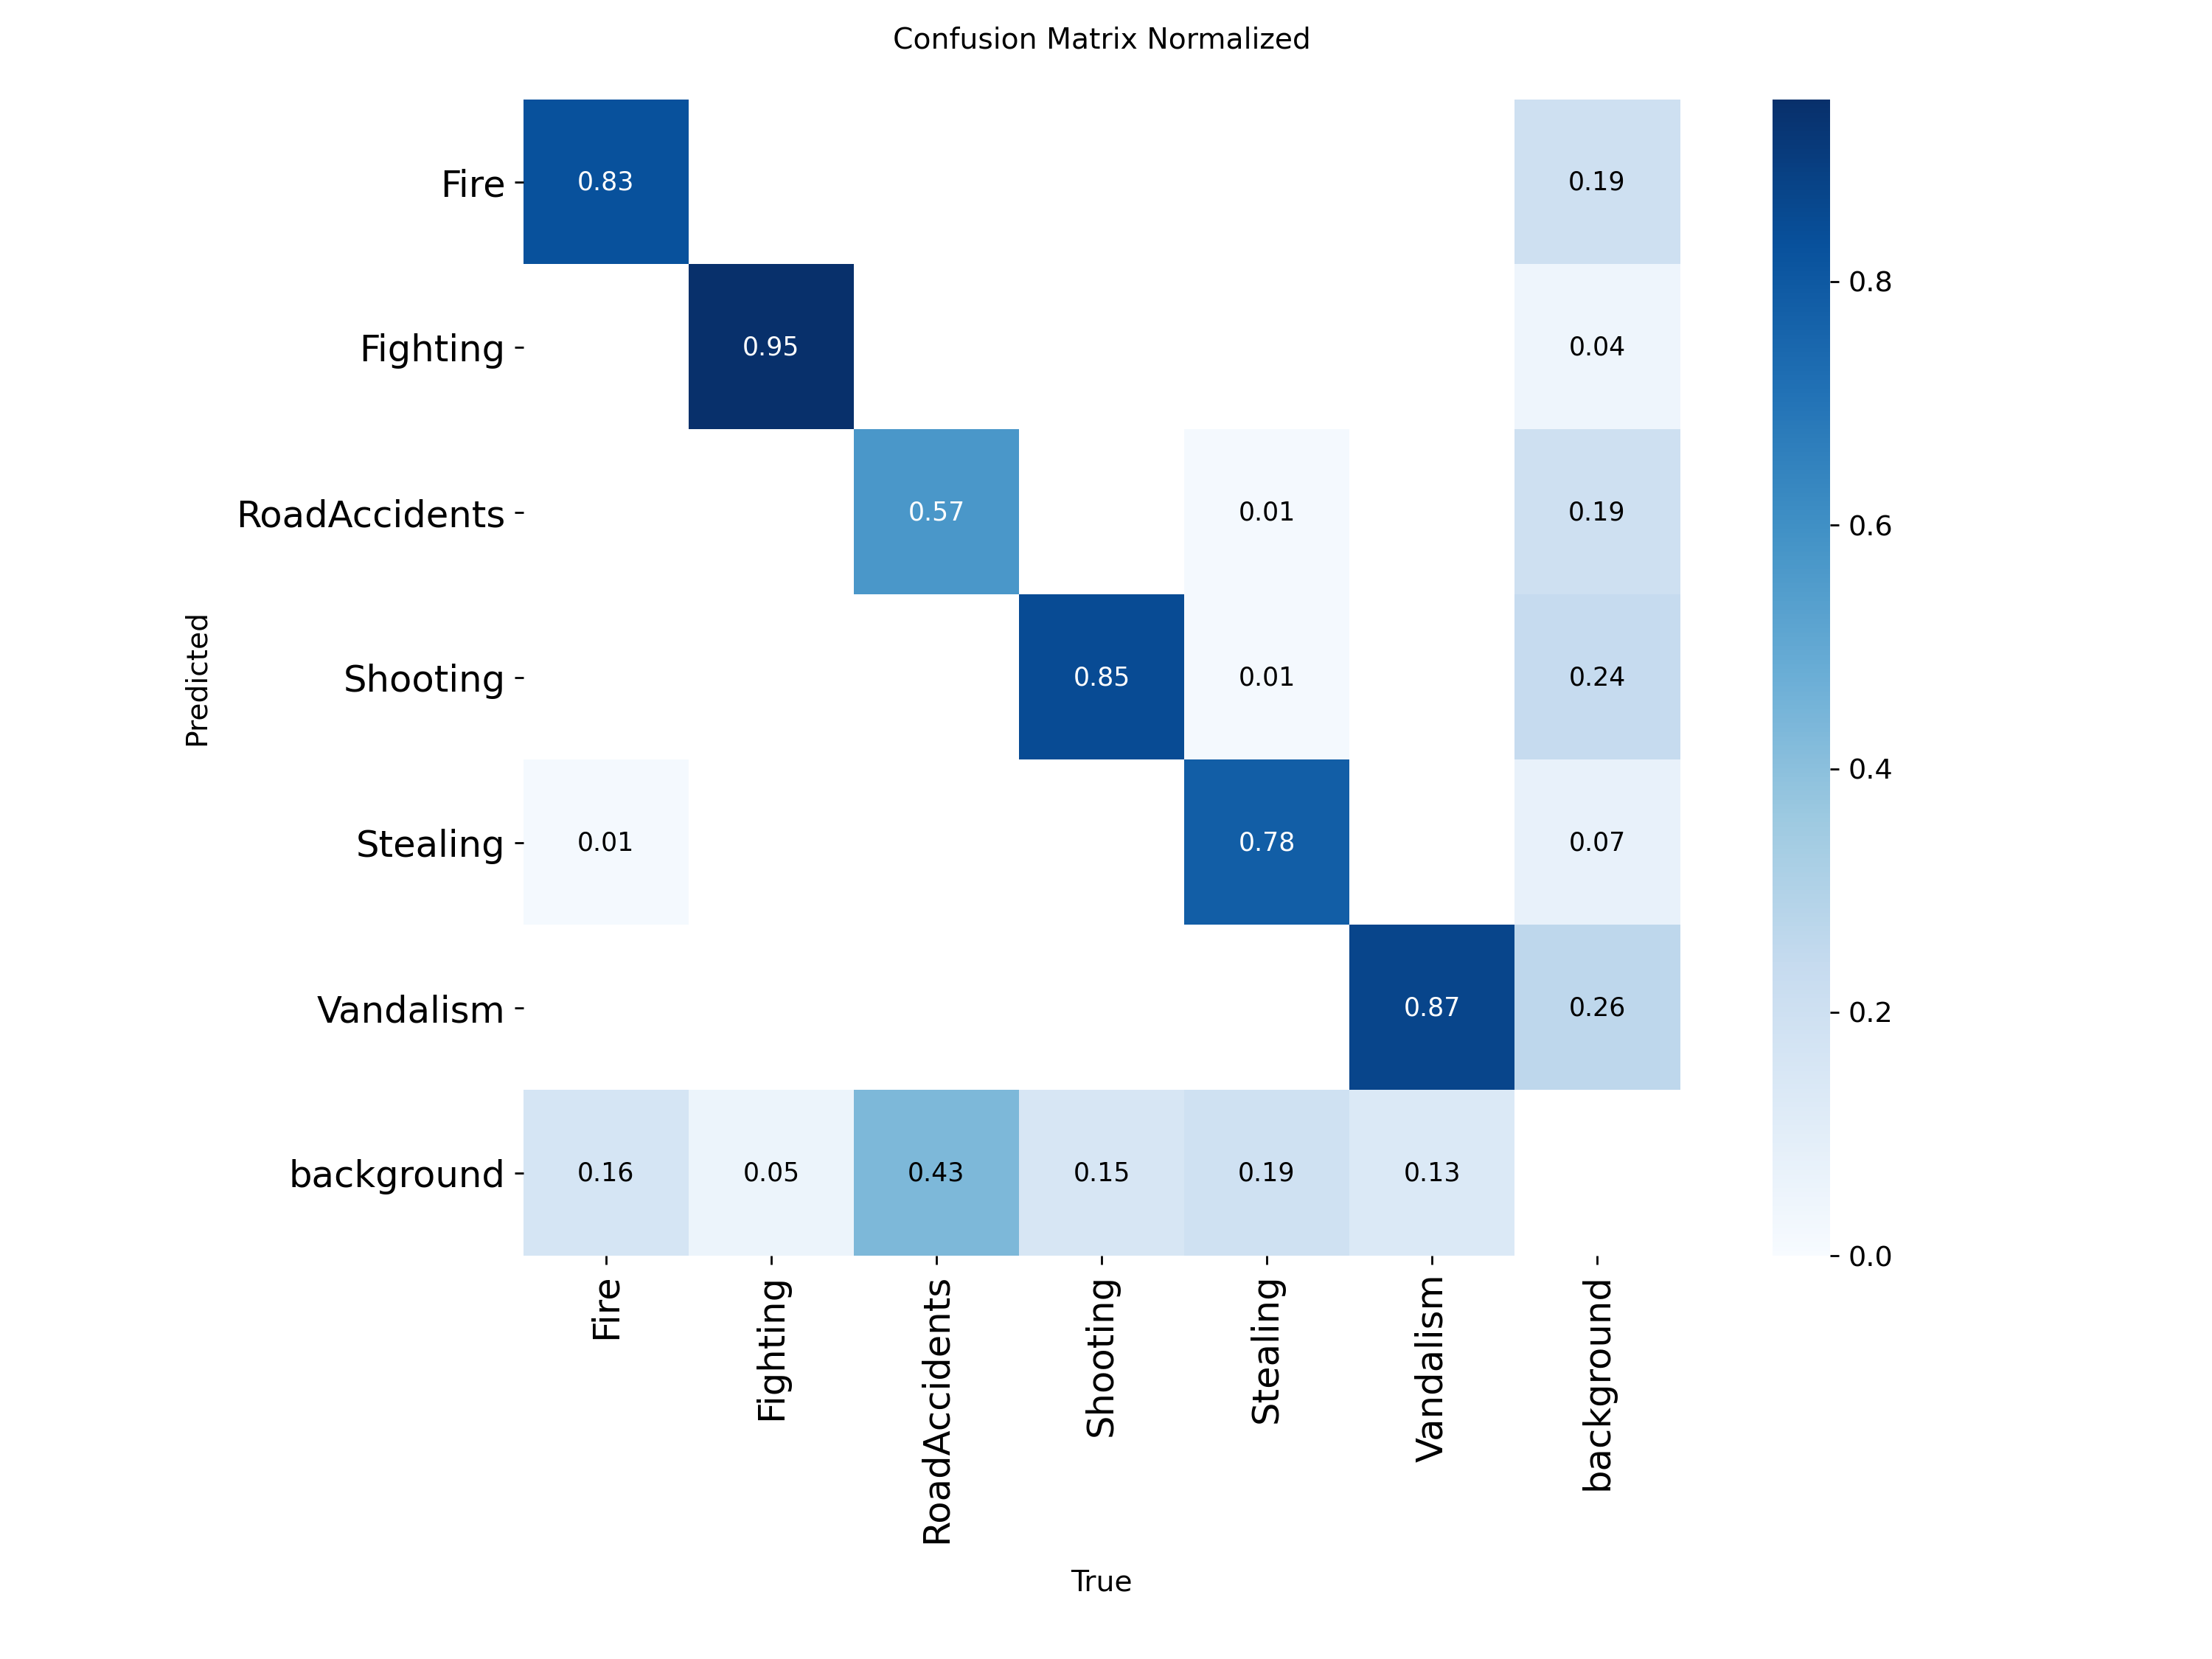

results.png


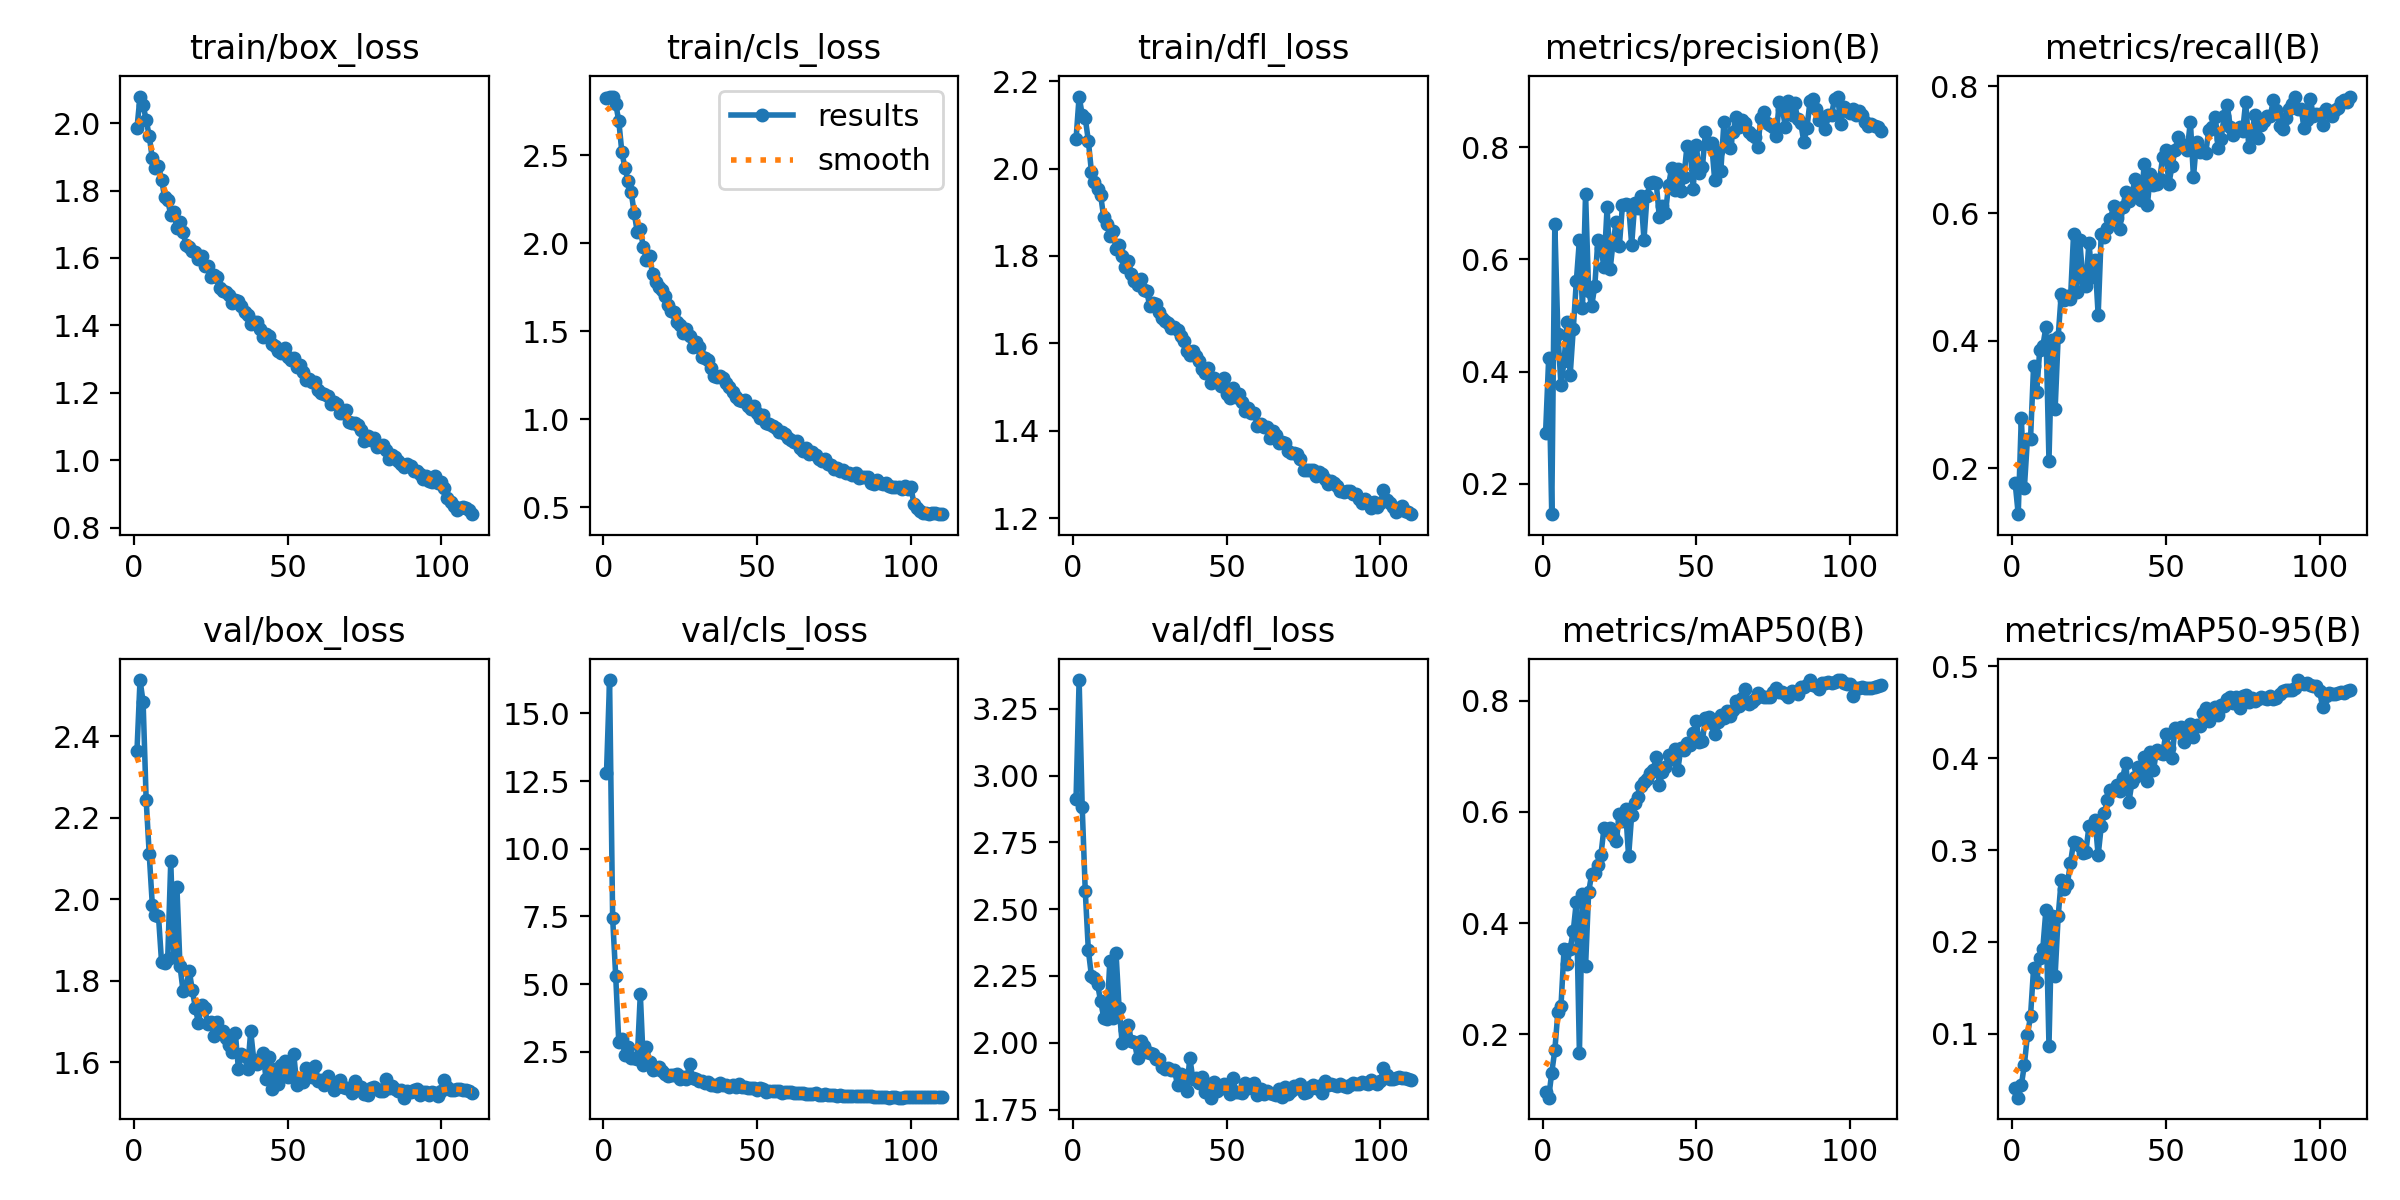

In [ ]:
from IPython.display import Image, display
from pathlib import Path

RUN_DIR = Path("/content/drive/MyDrive/DCSASS-yolo/runs")

plots = [
    "confusion_matrix_normalized.png",
    "results.png",
    "PR_curve.png",
    "F1_curve.png",
    "P_curve.png",
    "R_curve.png"
]

for p in plots:
    img_path = RUN_DIR / p
    if img_path.exists():
        print(p)
        display(Image(filename=str(img_path)))


In [ ]:
import os

def print_tree(base_path, indent="", max_items=3):
    """
    Recursively print folder structure:
    - Shows first 'max_items' files/folders in each directory
    - Prints "... +X more" if more items exist
    """
    try:
        items = sorted(os.listdir(base_path))
    except PermissionError:
        print(indent + "❌ [Permission Denied]")
        return

    for i, item in enumerate(items[:max_items]):
        path = os.path.join(base_path, item)
        if os.path.isdir(path):
            print(f"{indent}📂 {item}/")
            print_tree(path, indent + "   ", max_items=max_items)
        else:
            print(f"{indent}📄 {item}")
    if len(items) > max_items:
        print(f"{indent}... +{len(items) - max_items} more")


# Example usage
DATASET_ROOT = "/content/drive/MyDrive/DCSASS-yolo/dataset-with-label/Explosion/Explosion052_x264.mp4"
print(f"📂 Dataset root: {DATASET_ROOT}\n")
print_tree(DATASET_ROOT, max_items=7)


In [ ]:
from pathlib import Path
import subprocess

# ---------------- PATHS ----------------
CLIP_DIR = Path("/content/drive/MyDrive/DCSASS-yolo/dataset-with-label/Shooting/Shooting022_x264.mp4")
OUT_DIR = Path("/content/drive/MyDrive/DCSASS-yolo/input-videos")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_VIDEO = OUT_DIR / "shooting-1.mp4"

# ---------------- COLLECT & SORT CLIPS ----------------
clips = sorted(
    CLIP_DIR.glob("*.mp4"),
    key=lambda x: int(x.stem.split("_")[-1])
)

if not clips:
    raise SystemExit("No clips found to merge.")

print(f"Found {len(clips)} clips")

# ---------------- CREATE FFmpeg LIST FILE ----------------
list_file = CLIP_DIR / "clips.txt"

with open(list_file, "w") as f:
    for clip in clips:
        f.write(f"file '{clip.as_posix()}'\n")

# ---------------- RUN FFmpeg CONCAT ----------------
cmd = [
    "ffmpeg",
    "-y",
    "-f", "concat",
    "-safe", "0",
    "-i", str(list_file),
    "-c", "copy",
    str(OUTPUT_VIDEO)
]

subprocess.run(cmd, check=True)

print(f"\nMerged video saved at:\n{OUTPUT_VIDEO}")


Found 32 clips

Merged video saved at:
/content/drive/MyDrive/DCSASS-yolo/input-videos/shooting-1.mp4


In [ ]:
import cv2
from ultralytics import YOLO
from collections import defaultdict
from pathlib import Path

# ---------------- PATHS ----------------
VIDEO_PATH = "/content/drive/MyDrive/DCSASS-yolo/input-videos/merge-input-2.mp4"
OUT_DIR = Path("/content/drive/MyDrive/DCSASS-yolo/video-out")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_VIDEO = OUT_DIR / "merge-input-2.mp4"

MODEL_PATH = "/content/drive/MyDrive/DCSASS-yolo/runs/weights/best.pt"

# ---------------- LOAD MODEL ----------------
model = YOLO(MODEL_PATH)

# ---------------- VIDEO IO ----------------
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer = cv2.VideoWriter(
    str(OUTPUT_VIDEO),
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (w, h)
)

# ---------------- TEMPORAL LOGIC ----------------
PERSIST_SEC = 1.0
REQUIRED_FRAMES = int(fps * PERSIST_SEC)
CONF_THRESHOLD = 0.70

class_frame_counter = defaultdict(int)

print(f"FPS: {fps}")
print(f"Frames required for confirmation: {REQUIRED_FRAMES}")

frame_idx = 0

# ---------------- PROCESS VIDEO ----------------
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    results = model(frame, conf=0.25, verbose=False)[0]

    current_classes = set()

    if results.boxes is not None:
        for box in results.boxes:
            cls_id = int(box.cls.item())
            conf = float(box.conf.item())

            current_classes.add(cls_id)
            class_frame_counter[cls_id] += 1

            if class_frame_counter[cls_id] >= REQUIRED_FRAMES and conf >= CONF_THRESHOLD:
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                label_text = f"{model.names[cls_id]} {conf:.2f}"

                # -------- DRAW BOUNDING BOX --------
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

                # -------- LABEL INSIDE BOX --------
                (tw, th), baseline = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
                )

                # background rectangle inside the box
                cv2.rectangle(
                    frame,
                    (x1, y1),
                    (x1 + tw + 6, y1 + th + baseline + 6),
                    (0, 0, 255),
                    -1
                )

                # text on top of background
                cv2.putText(
                    frame,
                    label_text,
                    (x1 + 3, y1 + th + 3),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (255, 255, 255),
                    2
                )

                print(
                    f"[CONFIRMED] Frame {frame_idx} | "
                    f"Class: {model.names[cls_id]} | Conf: {conf:.2f}"
                )

    # reset counters for classes not seen in this frame
    for cls in list(class_frame_counter.keys()):
        if cls not in current_classes:
            class_frame_counter[cls] = 0

    writer.write(frame)

cap.release()
writer.release()

print(f"\nFiltered video saved at:\n{OUTPUT_VIDEO}")


FPS: 30.0
Frames required for confirmation: 30
[CONFIRMED] Frame 83 | Class: Fire | Conf: 0.90
[CONFIRMED] Frame 84 | Class: Fire | Conf: 0.90
[CONFIRMED] Frame 85 | Class: Fire | Conf: 0.89
[CONFIRMED] Frame 86 | Class: Fire | Conf: 0.89
[CONFIRMED] Frame 87 | Class: Fire | Conf: 0.90
[CONFIRMED] Frame 88 | Class: Fire | Conf: 0.90
[CONFIRMED] Frame 89 | Class: Fire | Conf: 0.89
[CONFIRMED] Frame 90 | Class: Fire | Conf: 0.87
[CONFIRMED] Frame 91 | Class: Fire | Conf: 0.90
[CONFIRMED] Frame 92 | Class: Fire | Conf: 0.90
[CONFIRMED] Frame 93 | Class: Fire | Conf: 0.84
[CONFIRMED] Frame 94 | Class: Fire | Conf: 0.76
[CONFIRMED] Frame 95 | Class: Fire | Conf: 0.76
[CONFIRMED] Frame 96 | Class: Fire | Conf: 0.77
[CONFIRMED] Frame 97 | Class: Fire | Conf: 0.80
[CONFIRMED] Frame 98 | Class: Fire | Conf: 0.83
[CONFIRMED] Frame 99 | Class: Fire | Conf: 0.83
[CONFIRMED] Frame 100 | Class: Fire | Conf: 0.84
[CONFIRMED] Frame 101 | Class: Fire | Conf: 0.84
[CONFIRMED] Frame 102 | Class: Fire | C

In [ ]:
import cv2
from ultralytics import YOLO
from collections import defaultdict
from pathlib import Path

# ================== PATHS ==================
INPUT_DIR = Path("/content/drive/MyDrive/DCSASS-yolo/input-videos")
OUT_DIR = Path("/content/drive/MyDrive/DCSASS-yolo/video-out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = "/content/drive/MyDrive/DCSASS-yolo/runs/weights/best.pt"

# ================== PARAMETERS ==================
PERSIST_SEC = 1.5          # activity must persist for >= 1.5 seconds
CONF_THRESHOLD = 0.70
YOLO_CONF = 0.25           # raw YOLO confidence

VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv")

# ================== LOAD MODEL ==================
model = YOLO(MODEL_PATH)

# ================== PROCESS ALL VIDEOS ==================
videos = sorted([v for v in INPUT_DIR.iterdir() if v.suffix.lower() in VIDEO_EXTS])

print(f"Found {len(videos)} videos")

for video_path in videos:
    print(f"\nProcessing: {video_path.name}")

    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    required_frames = int(fps * PERSIST_SEC)

    out_path = OUT_DIR / video_path.name
    writer = cv2.VideoWriter(
        str(out_path),
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (w, h)
    )

    print(f"FPS: {fps:.2f} | Frames required: {required_frames}")

    class_frame_counter = defaultdict(int)
    frame_idx = 0

    # ================== FRAME LOOP ==================
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        results = model(frame, conf=YOLO_CONF, verbose=False)[0]

        current_classes = set()

        if results.boxes is not None:
            for box in results.boxes:
                cls_id = int(box.cls.item())
                conf = float(box.conf.item())

                current_classes.add(cls_id)
                class_frame_counter[cls_id] += 1

                if (
                    class_frame_counter[cls_id] >= required_frames
                    and conf >= CONF_THRESHOLD
                ):
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    label = f"{model.names[cls_id]} {conf:.2f}"

                    # ---- DRAW BOX ----
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

                    (tw, th), baseline = cv2.getTextSize(
                        label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
                    )

                    cv2.rectangle(
                        frame,
                        (x1, y1),
                        (x1 + tw + 6, y1 + th + baseline + 6),
                        (0, 0, 255),
                        -1
                    )

                    cv2.putText(
                        frame,
                        label,
                        (x1 + 3, y1 + th + 3),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (255, 255, 255),
                        2
                    )

                    print(
                        f"[CONFIRMED] {video_path.name} | "
                        f"Frame {frame_idx} | "
                        f"{model.names[cls_id]} ({conf:.2f})"
                    )

        # Reset counters for classes not present in this frame
        for cls in list(class_frame_counter.keys()):
            if cls not in current_classes:
                class_frame_counter[cls] = 0

        writer.write(frame)

    cap.release()
    writer.release()

    print(f"Saved output → {out_path}")

print("\nAll videos processed successfully.")


Streaming output truncated to the last 5000 lines.
[CONFIRMED] merge-input-2.mp4 | Frame 5758 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5759 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5760 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5761 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5762 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5763 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5764 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5765 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5766 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5767 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5768 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5769 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5770 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5771 | Vandalism (0.80)
[CONFIRMED] merge-input-2.mp4 | Frame 5772 | Vandalism (0.78)
[CONFIRMED] merge-i